<a href="https://colab.research.google.com/github/sushi15/HASOC-Code-Mixed-Tamil/blob/main/hasoc_tamil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import itertools
import os

import matplotlib.pylab as plt 
from matplotlib import pyplot
import numpy as np 
import pandas as pd 

import tensorflow as tf
import tensorflow_hub as hub 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.callbacks import ModelCheckpoint 

import keras 
from keras.models import Model
from keras import models
from keras import layers
from keras import optimizers 
from tensorflow.python.keras.layers import Dense, Embedding, GlobalMaxPool1D, Dropout
from tensorflow.python.keras import Sequential 
from tensorflow.keras.layers import InputLayer

import random 
import re
import nltk
nltk.download('punkt', 'stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer() 

from sklearn.preprocessing import LabelEncoder

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth) 

[nltk_data] Downloading package punkt to stopwords...
[nltk_data]   Package punkt is already up-to-date!


## Loading the data

In [ ]:
#Dataset

downloaded = drive.CreateFile({'id':"1f30jPPclwN1dJ8Syht_j6DT4xRjq-1AN"}) 
downloaded.GetContentFile('tamil_offensive_train.tsv') 

In [ ]:
#Dataset

downloaded = drive.CreateFile({'id':"1-iWGGx6fDvoh9YUjw4igil24ipwF4ZPl"}) 
downloaded.GetContentFile('tamil_offensive_withoutlabels_test.tsv.csv') 

In [ ]:
train_data = pd.read_csv('tamil_offensive_train.tsv', sep='\t', header=0, encoding="utf-8") #Dataframe

In [ ]:
test_data = pd.read_csv('tamil_offensive_withoutlabels_test.tsv.csv', sep='\t', header=0, encoding="utf-8") #Dataframe

In [ ]:
train_data['category'].value_counts()

NOT          4724
OFF          1153
not-Tamil       3
Name: category, dtype: int64

In [ ]:
le = LabelEncoder()
train_data['category'] = le.fit_transform(train_data['category']) 

In [ ]:
train_data['category'].value_counts()

0    4724
1    1153
2       3
Name: category, dtype: int64

In [ ]:
y_train = train_data['category'].values 
y_train = to_categorical(y_train) 
y_train.shape 

(5880, 3)

In [ ]:
x_train = train_data['text'].values.tolist()

In [ ]:
y_train

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
# x_train

In [ ]:
x_test = test_data['text'].values.tolist()

In [ ]:
# x_test

# Preprocessing

In [ ]:
type(x_train)

list

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 5000) 
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
# x_val = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index


In [ ]:
from keras.preprocessing.sequence import pad_sequences

max = 100

x_train = pad_sequences(x_train, padding = 'post', maxlen = max)
# x_val = pad_sequences(x_val, padding = 'post', maxlen = max)
x_test = pad_sequences(x_test, padding = 'post', maxlen = max)

In [ ]:
training_set_size = 4000 #@param {type:"slider", min:0, max:5880, step:1000}
x_val = x_train[training_set_size:, :]
x_train = x_train[:training_set_size, :] 
y_val = y_train[training_set_size:, :] 
y_train = y_train[:training_set_size, :] 

print(x_val.shape) 
print(x_train.shape)
print(y_val.shape) 
print(y_train.shape)

(1880, 100)
(4000, 100)
(1880, 3)
(4000, 3)


In [ ]:
x_train.shape

(4000, 100)

In [ ]:
x_val.shape

(1880, 100)

In [ ]:
print(x_train[0, :])

[4175  205  153    3    1    4    6    2    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [ ]:
print(x_test[0, :])

[ 386  995   86  386 1209    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


# Defining the model

In [ ]:
BATCH_SIZE = 512 #@param {type:"slider", min:0, max:512, step:2}

In [ ]:
EPOCH_SIZE = 25 #@param {type:"integer"}

In [ ]:
input_dim = x_train.shape[1]

In [ ]:
embedding_dim = 50
# vocab_size = len(vectorizer.vocabulary_)

model = Sequential() 
model.add(InputLayer(input_shape = (x_train.shape[1]))) 
# model.add(Dropout(0.35))
model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = max))
# model.add(layers.Flatten()) 
# model.add(Dropout(0.2))
model.add(GlobalMaxPool1D()) 
model.add(Dropout(0.2)) 
model.add(Dense(10, input_dim = input_dim, activation='relu')) 
# model.add(Dropout(0.2))
model.add(Dense(3, activation='sigmoid')) 

In [ ]:
model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           1060300   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 50)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 33        
Total params: 1,060,843
Trainable params: 1,060,843
Non-trainable params: 0
_________________________________________________________________


# Training

In [ ]:
history=model.fit(x_train, y_train, 
                  steps_per_epoch = y_train.shape[0] // BATCH_SIZE, 
                  epochs = EPOCH_SIZE, 
                  validation_data = (x_val, y_val), 
                  batch_size = BATCH_SIZE, 
                  validation_steps = y_val.shape[0] // BATCH_SIZE,
                    )

Epoch 1/25
7/7 [==============================] - 1s 41ms/step - loss: 1.0729 - accuracy: 0.7126 - val_loss: 1.0484 - val_accuracy: 0.8099
Epoch 2/25
7/7 [==============================] - 0s 22ms/step - loss: 1.0310 - accuracy: 0.7987 - val_loss: 1.0096 - val_accuracy: 0.8105
Epoch 3/25
7/7 [==============================] - 0s 22ms/step - loss: 0.9886 - accuracy: 0.8036 - val_loss: 0.9685 - val_accuracy: 0.8105
Epoch 4/25
7/7 [==============================] - 0s 22ms/step - loss: 0.9464 - accuracy: 0.7976 - val_loss: 0.9255 - val_accuracy: 0.8105
Epoch 5/25
7/7 [==============================] - 0s 24ms/step - loss: 0.9024 - accuracy: 0.8005 - val_loss: 0.8808 - val_accuracy: 0.8105
Epoch 6/25
7/7 [==============================] - 0s 21ms/step - loss: 0.8563 - accuracy: 0.8033 - val_loss: 0.8348 - val_accuracy: 0.8105
Epoch 7/25
7/7 [==============================] - 0s 21ms/step - loss: 0.8117 - accuracy: 0.7979 - val_loss: 0.7880 - val_accuracy: 0.8105
Epoch 8/25
7/7 [===========

# Plots 

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


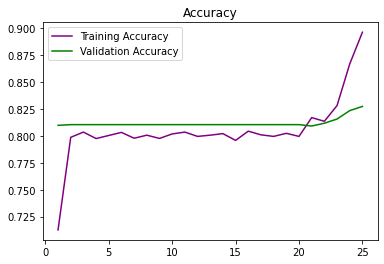

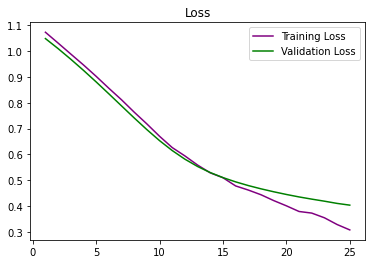

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Accuracy')
plt.plot(epochs, acc, 'purple', label='Training Accuracy')
plt.plot(epochs, val_acc, 'green', label = 'Validation Accuracy')
plt.legend()

plt.figure()
plt.title('Loss')
plt.plot(epochs, loss, 'purple', label = 'Training Loss')
plt.plot(epochs, val_loss, 'green', label = 'Validation Loss')

plt.legend()

plt.show()

# Predictions

In [ ]:
predictions = model.predict(x_test)

In [ ]:
predictions

array([[0.8299044 , 0.30966574, 0.07208166],
       [0.86344767, 0.21344341, 0.0534878 ],
       [0.77926993, 0.42792174, 0.09184191],
       ...,
       [0.76261425, 0.6656275 , 0.06344661],
       [0.8642203 , 0.21195124, 0.05318445],
       [0.75382423, 0.5251867 , 0.10111348]], dtype=float32)